#### Global hyperpameters

In [24]:
SEED                    = 12345   # global random seed for better reproducibility
GLM_SELECTION_THRESHOLD = 0.001   # threshold above which a GLM coefficient is considered "selected"

#### python imports and inits

In [25]:
import pandas as pd
import numpy as np

# Visualisations
import matplotlib.pyplot as plt 
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import norm, skew
from statistics import mode
from scipy.special import boxcox1p

# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso, Ridge, RidgeCV, ElasticNet
import xgboost as xgb
#import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
#from catboost import Pool, CatBoostRegressor, cv

import sys
import warnings

## 1. Explore, and Prepare UCI Credit Card Default Data

#### Import data and reformat

In [26]:
df_train = pd.read_csv('D:\Class\machine learning\house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('D:\Class\machine learning\house-prices-advanced-regression-techniques/test.csv')

#### determine data types

In [27]:
# Categorical boolean mask
mask = df_train.dtypes==object

# filter categorical columns using mask and turn it into a list
cats = df_train.columns[mask].tolist()

#filter numeric/float columns
nums = df_train.columns[~mask].tolist()

print("Categorical =" , cats)
print()
print("Numeric = ", nums )

Categorical = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numeric =  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'Woo

## Split into to train and validation (before doing data prep!!!)

In [28]:
split_ratio = 0.9 # 80%/20% train/test split

# execute split
split = np.random.rand(len(df_train)) < split_ratio
train = df_train[split]
valid = df_train[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

#summarize test set
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 1307, columns = 81
Validation data rows = 153, columns = 81
Test data rows = 1459, columns = 80


#### describe all the categorical values in the original train model -- df_train

In [29]:
#describe categorical variables
df_train[cats].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


In [30]:
df_train[nums].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Since **`Utilities`** have only 2 unique values but 1459 out of 1460 values are the same, drop the column.

In [31]:
#drop column
droplist = ["Street","Utilities"]
train = train.drop(columns = droplist)
valid = valid.drop(columns = droplist)
test = test.drop(columns = droplist)

### Summarize and handle missing value of training data

In [32]:
missingsum = train.isnull().sum()
misslist = missingsum[missingsum>0].sort_values()
misslist.to_frame(name="Missing Value Counts")

,Missing Value Counts
Electrical,1
MasVnrType,7
MasVnrArea,7
BsmtQual,32
BsmtCond,32
BsmtFinType1,32
BsmtFinType2,32
BsmtExposure,33
GarageCond,74
GarageQual,74


In [33]:
#if columns contain 15% or missing values, drop it
drop_threshold = int(len(train) * 0.15)
mask = misslist < drop_threshold

#filter the variables
miss = list(misslist.index[mask])
drop = [name for name in misslist.index if name not in miss]

print("Missing values are:",miss)
print()
print("Drop the following values:",drop)

Missing values are: ['Electrical', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType', 'GarageYrBlt']

Drop the following values: ['LotFrontage', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']


#### remove columns with 15% or more missing values

In [34]:
#remove columns stated above
train = train.drop(columns = drop)
valid = valid.drop(columns = drop)
test = test.drop(columns = drop)

#### determine the type of missing data

In [35]:
#filter the categorical missing variables
miss_cats = [name for name in miss if name in cats]

#filter the numeric missing variables
miss_nums = [name for name in nums if name in miss]

print("Categorical missing variables are:", miss_cats)
print()
print("Categorical numeric variables are:", miss_nums)

Categorical missing variables are: ['Electrical', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'GarageCond', 'GarageQual', 'GarageFinish', 'GarageType']

Categorical numeric variables are: ['MasVnrArea', 'GarageYrBlt']


#### describe the missing data

In [36]:
#describe the data
print(train[miss_cats].describe())
print()
print(train[miss_nums].describe())

       Electrical MasVnrType BsmtQual BsmtCond BsmtFinType1 BsmtFinType2  \
count        1306       1300     1275     1275         1275         1275   
unique          5          4        4        4            6            6   
top         SBrkr       None       TA       TA          Unf          Unf   
freq         1188        767      590     1175          379         1122   

       BsmtExposure GarageCond GarageQual GarageFinish GarageType  
count          1274       1233       1233         1233       1233  
unique            4          5          5            3          6  
top              No         TA         TA          Unf     Attchd  
freq            853       1184       1170          539        779  

        MasVnrArea  GarageYrBlt
count  1300.000000  1233.000000
mean    104.450769  1978.202758
std     177.246144    24.689884
min       0.000000  1900.000000
25%       0.000000  1961.000000
50%       0.000000  1979.000000
75%     168.000000  2002.000000
max    1378.000000  20

### impute the data

* **`Electrical`**: Electrical: Electrical system
* **`MasVnrType`**: Masonry veneer type
* **`MasVnrArea`**: Masonry veneer type

For the above variables, filling the missing values with the most frequent records

In [37]:
#set the variable list
var = ["Electrical","MasVnrType","MasVnrArea"]

#use loop to fill the missing value with the most frequent records
for xs in var:
    train[xs] = train[xs].fillna(train[xs].value_counts().index[0])
    valid[xs] = valid[xs].fillna(valid[xs].value_counts().index[0])
    test[xs] = test[xs].fillna(test[xs].value_counts().index[0])

#check the result
for xs in var:
    print("training", xs, "missing",train[xs].isnull().sum(),
         ", valid", xs, "missing",valid[xs].isnull().sum(),
         ", test", xs, "missing",test[xs].isnull().sum(),)

training Electrical missing 0 , valid Electrical missing 0 , test Electrical missing 0
training MasVnrType missing 0 , valid MasVnrType missing 0 , test MasVnrType missing 0
training MasVnrArea missing 0 , valid MasVnrArea missing 0 , test MasVnrArea missing 0


* **`BsmtCond`**: Evaluates the general condition of the basement
* **`BsmtQual`**: Evaluates the height of the basement
* **`BsmtFinType1`**: Rating of basement finished area
* **`BsmtFinType2`**: Rating of basement finished area (if multiple types)
* **`BsmtExposure`**: Refers to walkout or garden level walls

For the above variables, NA means no basement. Filling missing variables to None.

In [38]:
# since NA means there is no basement, we change "NA" to "None"

#set variable name list
var = ["BsmtCond","BsmtQual","BsmtFinType1","BsmtFinType2","BsmtExposure"]

#use loop to change data
for xs in var:
    train[xs] = train[xs].fillna(value = "None")
    valid[xs] = valid[xs].fillna(value = "None")
    test[xs] = test[xs].fillna(value = "None")
    
#double check result
for xs in var:
    print("training", xs, "missing",train[xs].isnull().sum(),
         ", valid", xs, "missing",valid[xs].isnull().sum(),
         ", test", xs, "missing",test[xs].isnull().sum(),)

training BsmtCond missing 0 , valid BsmtCond missing 0 , test BsmtCond missing 0
training BsmtQual missing 0 , valid BsmtQual missing 0 , test BsmtQual missing 0
training BsmtFinType1 missing 0 , valid BsmtFinType1 missing 0 , test BsmtFinType1 missing 0
training BsmtFinType2 missing 0 , valid BsmtFinType2 missing 0 , test BsmtFinType2 missing 0
training BsmtExposure missing 0 , valid BsmtExposure missing 0 , test BsmtExposure missing 0


# this part remained to be solved↓

Since BsmtQual, BsmtCond, BsmtFinType1, BsmtExposure, BsmtFinType2 are highly correlated and "none" means "no basement", we need to make sure all these features consistently express "has a basement" or "not has a basement

In [39]:
# find out how many rows have inconsistent value

Id_basement=[]


df_sub_1=train.loc[train['BsmtQual']=='None',['Id','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']]
len1=df_sub_1.shape[0]

if(len1 != 0):
    for index,row in df_sub_1.iterrows():
        if(row['BsmtCond'] != 'None') |(row['BsmtFinType1'] != 'None') | (row['BsmtExposure'] != 'None'):
            Id_basement.append(row["Id"])


df_sub_2=df_train.loc[df_train['BsmtQual']!='None',['Id','BsmtCond','BsmtFinType1','BsmtExposure']]
len2=df_sub_2.shape[0]

if(len2 !=0):
    for index,row in df_sub_2.iterrows():
        if(row['BsmtCond'] == 'None') |(row['BsmtFinType1'] == 'None') | (row['BsmtExposure'] == 'None'):
            Id_basement.append(row["Id"])
        

Id_basement

[]

* **`GarageCond`**: Evaluates the Garage condition
* **`GarageQual`**: Garage quality
* **`GarageFinish`**: Interior finish of the garage
* **`GarageType`**: Garage location
* **`GarageYrBlt`**: Year garage was built

For "GarageCond","GarageQual","GarageFinish","GarageType", NA means no garages.

In [40]:
#set variable name list
var = ["GarageCond","GarageQual","GarageFinish","GarageType"]

#fill missing variables in var with None
for xs in var:
    train[xs] = train[xs].fillna(value = "None")
    valid[xs] = valid[xs].fillna(value = "None")
    test[xs] = test[xs].fillna(value = "None")
    
#filling "GarageYrBlt" with "0"
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(value = 0)
valid['GarageYrBlt'] = valid['GarageYrBlt'].fillna(value = 0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(value = 0)

#double check result
var.append("GarageYrBlt")
for xs in var:
    print("training", xs, "missing",train[xs].isnull().sum(),
         ", valid", xs, "missing",valid[xs].isnull().sum(),
         ", test", xs, "missing",test[xs].isnull().sum(),)

training GarageCond missing 0 , valid GarageCond missing 0 , test GarageCond missing 0
training GarageQual missing 0 , valid GarageQual missing 0 , test GarageQual missing 0
training GarageFinish missing 0 , valid GarageFinish missing 0 , test GarageFinish missing 0
training GarageType missing 0 , valid GarageType missing 0 , test GarageType missing 0
training GarageYrBlt missing 0 , valid GarageYrBlt missing 0 , test GarageYrBlt missing 0


Verify if there are inconsistent values among GarageQual,GarageFinish,GarageType,GarageYrBlt,GarageCond,GarageCars and GarageArea. 

In [41]:
#check inconsistency
Id_Garage=[]

df_sub_1_G=train.loc[train['GarageQual']=='None',['Id','GarageFinish','GarageType','GarageCond','GarageCars','GarageArea','GarageYrBlt']]

len_G_1=df_sub_1_G.shape[0]

if(len_G_1 != 0):
    for index,row in df_sub_1_G.iterrows():
        if(row['GarageFinish'] != 'None') |(row['GarageType'] != 'None') | (row['GarageCond'] != 'None')| (row['GarageCars'] != 0) | (row['GarageArea'] != 0) | (row['GarageYrBlt'] != 0):
            Id_Garage.append(row["Id"])

df_sub_2_G=train.loc[train['GarageQual'] != 'None',['Id','GarageFinish','GarageType','GarageCond','GarageCars','GarageArea','GarageYrBlt']]

len_G_2=df_sub_2_G.shape[0]

if(len_G_2!=0):
    for index,row in df_sub_2_G.iterrows():
        if(row['GarageFinish'] == 'None') |(row['GarageType'] == 'None') | (row['GarageCond'] == 'None')| (row['GarageCars'] == 0) | (row['GarageArea'] == 0) | (row['GarageYrBlt'] == 0):
            Id_Garage.append(row["Id"])
             
print(Id_Garage)

[]


# if there is any inconsistency fix all of them as "None" and "0"
if len(Id_Garage) != 0:
    df_train.loc[df_train['Id'].isin(Id),['GarageQual','GarageFinish','GarageType','GarageCond','GarageCars','GarageArea','GarageYrBlt']]=['None','None','None','None',0,0,0]

## 2. Train Models

#### assign model roles

#### log transform of Y variable -- SalePrice

0    12.247694
1    12.109011
2    12.317167
4    12.429216
5    11.870600
Name: SalePrice, dtype: float64


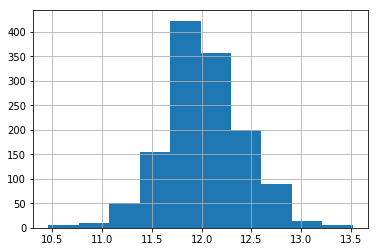

In [42]:
#check log transformation on the "SalePrice" -looks good
train["SalePrice"].apply(np.log).hist()
#valid["SalePrice"].apply(np.log).hist()

#apply log transformation
train["SalePrice"] = np.log(train["SalePrice"])
valid["SalePrice"] = np.log(valid["SalePrice"])
print(train["SalePrice"].head())

### create dummy variables

In [43]:
#deep copy the data frame
train_glm = train.copy()
train_glm_copy = train.copy()

valid_glm = valid.copy()
valid_glm_copy = train.copy()

test_glm = test.copy()

# Categorical boolean mask
mask = train_glm.dtypes==object

# filter categorical columns using mask and turn it into a list
cats = train_glm.columns[mask].tolist()

#### one-hot encode vategorical variables

In [44]:
#one-hot encode training frame
train_glm = pd.get_dummies(train_glm)

#one-hot encode valid frame
valid_glm = pd.get_dummies(valid_glm)

#one-hot encode test frame
test_glm = pd.get_dummies(test_glm)

#keep only the same new columns in the encoded new frames

comm_train=list(set(train_glm.columns).intersection(set(valid_glm.columns)))
comm_all=list(set(comm_train).intersection(set(test_glm.columns)))


SalePrice_train=train_glm_copy["SalePrice"]
SalePrice_valid=valid_glm_copy["SalePrice"]


train_glm=train_glm[comm_all]
train_glm["SalePrice"]=SalePrice_train

valid_glm["SalePrice"]=SalePrice_valid

test_glm=test_glm[comm_all]

### 2.1 GLM feature selection

#### split train data into new train data set and validate data

In [45]:
#assign input and response variables
y_name = "SalePrice"
x_names = [name for name in train_glm if name not in [y_name, "Id"]]

print('y_name =', y_name)
print()
print('x_names =', x_names)

y_name = SalePrice

x_names = ['HouseStyle_1.5Fin', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'SaleCondition_Alloca', 'Exterior1st_HdBoard', 'BsmtFinType2_Rec', 'BsmtQual_Fa', 'Condition1_RRAe', 'ExterQual_Fa', 'RoofMatl_WdShake', 'ExterCond_Gd', 'BsmtExposure_None', 'PavedDrive_Y', 'Condition1_Artery', 'MSZoning_RM', 'SaleCondition_Normal', 'BsmtFinType1_LwQ', 'Neighborhood_Edwards', 'HouseStyle_2Story', 'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Heating_GasA', 'GarageQual_Gd', 'HouseStyle_SFoyer', 'LotConfig_Corner', 'SaleCondition_Partial', 'Exterior1st_AsbShng', 'Foundation_PConc', 'BsmtFinType2_Unf', 'GarageType_2Types', 'LotConfig_FR2', 'PavedDrive_N', 'LandSlope_Mod', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'Exterior2nd_CmentBd', 'MSZoning_FV', 'Neighborhood_NridgHt', 'BsmtQual_TA', 'LandContour_Lvl', 'Exterior1st_Stucco', 'Neighborhood_Timber', 'Exterior2nd_Plywood', 'GarageArea', 'LandContour_HLS', 'FullBath', 'Neighborhood_CollgCr', 'ExterQual_TA', '1stFlrSF', 'Exterio

#### display the glm

### find some percentile of yhat in the validadtion data

In [47]:
yhat = best_glm.predict(h2o.H2OFrame(valid_glm))

NameError: name 'best_glm' is not defined

In [48]:
#merge
glm_yhat_valid = pd.concat([valid_glm.reset_index(drop=True),
                           yhat.as_data_frame()],
                           axis = 1)

#rename
glm_yhat_valid = glm_yhat_valid.rename(columns = {"predict":"p_SalePrice"})

#find percentile
glm_percentile_dict = explain.get_percentile_dict("p_SalePrice",glm_yhat_valid,"Id")

#display
glm_percentile_dict

NameError: name 'yhat' is not defined

In [137]:
glm_yhat_valid[["SalePrice","p_SalePrice"]].head(10)

,SalePrice,p_SalePrice
0,12.247694,12.246386
1,11.911702,12.015154
2,11.842229,11.765183
3,12.991753,13.049320
4,11.849398,11.696641
5,12.468437,12.444591
6,11.724806,11.692810
7,11.804849,11.813087
8,12.230765,12.236477
9,12.040608,11.883680


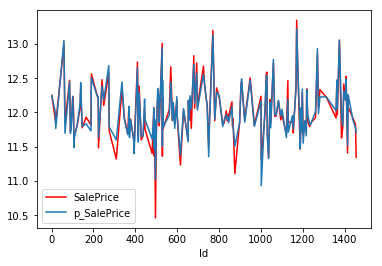

In [138]:
#'get current axis'
ax = plt.gca()

glm_yhat_valid.plot(x = "Id",y = "SalePrice",color = "red",ax=ax)
glm_yhat_valid.plot(x = "Id",y = "p_SalePrice", ax = ax)

#plt.show()

## generate submission file

In [140]:
from math import exp, expm1

In [141]:
def gen_submission(data):
    
    """
    This file will generate a submission csv file for the kaggle competition.
    It should contain only two columns: Id and SalePrice.
    
    data: the test set
    """
    
    #use the gbm model for selected feature
    #p_SalePrice = best_glm.predict(h2o.H2OFrame(data))
    p_SalePrice = p_SalePrice.as_data_frame()

    #format a new data frame
    Id = test_glm["Id"]
    sub = pd.DataFrame(data = Id)
    sub["SalePrice"] = p_SalePrice
    
    #make exponential
    sub["SalePrice"] = np.exp(sub["SalePrice"])
    
    #export csv file
    sub.to_csv(r"../submission.csv",index = False, header = True)
    
    return sub

In [142]:
sub_file = gen_submission(test_glm)
sub_file.head(10)

D:\Anaconda3\lib\site-packages\h2o\job.py:70: UserWarning: Test/Validation dataset is missing column 'Exterior1st_Stone': substituting in a column of NaN
  warnings.warn(w)


,Id,SalePrice
0,1461,119876.770938
1,1462,148936.709398
2,1463,171626.188265
3,1464,197090.002385
4,1465,208697.518821
5,1466,170096.922006
6,1467,187955.957794
7,1468,166277.370802
8,1469,188669.607877
9,1470,123118.204758


## Construct GBM

#### 1. gbm with selected feature

## Xgboost

In [ ]:
# def rmse_cv(model):
#     rmse = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 10))
#     return(rmse)

In [ ]:
# model_xgb = xgb.XGBRegressor(colsample_bytree=0.2,
#                              learning_rate=0.06,
#                              max_depth=3,
#                              n_estimators=1150)
# cv_xgb = rmse_cv(model_xgb).mean()

In [62]:
x=train_glm[x_names]
y=train_glm['SalePrice']
#df.drop(columns=['B', 'C'])
test_glm.drop(columns="Id")
test_glm.shape[1]


224

In [59]:
model_xgb = xgb.XGBRegressor(n_estimators=1150, 
                             max_depth=3, 
                             learning_rate=0.06,
                             colsample_bytree=0.2) 

model_xgb.fit(x, y)

[13:22:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.2, learning_rate=0.06, n_estimators=1150)

In [54]:
pred_xgb=model_xgb.predict(test_glm)

ValueError: feature_names mismatch: ['HouseStyle_1.5Fin', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'SaleCondition_Alloca', 'Exterior1st_HdBoard', 'BsmtFinType2_Rec', 'BsmtQual_Fa', 'Condition1_RRAe', 'ExterQual_Fa', 'RoofMatl_WdShake', 'ExterCond_Gd', 'BsmtExposure_None', 'PavedDrive_Y', 'Condition1_Artery', 'MSZoning_RM', 'SaleCondition_Normal', 'BsmtFinType1_LwQ', 'Neighborhood_Edwards', 'HouseStyle_2Story', 'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Heating_GasA', 'GarageQual_Gd', 'HouseStyle_SFoyer', 'LotConfig_Corner', 'SaleCondition_Partial', 'Exterior1st_AsbShng', 'Foundation_PConc', 'BsmtFinType2_Unf', 'GarageType_2Types', 'LotConfig_FR2', 'PavedDrive_N', 'LandSlope_Mod', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'Exterior2nd_CmentBd', 'MSZoning_FV', 'Neighborhood_NridgHt', 'BsmtQual_TA', 'LandContour_Lvl', 'Exterior1st_Stucco', 'Neighborhood_Timber', 'Exterior2nd_Plywood', 'GarageArea', 'LandContour_HLS', 'FullBath', 'Neighborhood_CollgCr', 'ExterQual_TA', '1stFlrSF', 'Exterior2nd_Wd Sdng', 'Foundation_Stone', 'Foundation_BrkTil', 'Condition2_Feedr', 'CentralAir_Y', 'Exterior2nd_Stucco', 'GarageType_Detchd', 'Functional_Typ', 'SaleType_Oth', 'Neighborhood_Gilbert', 'GarageFinish_Unf', 'TotalBsmtSF', 'ExterQual_Gd', 'ScreenPorch', 'Exterior1st_Wd Sdng', 'Exterior1st_BrkFace', 'BsmtQual_Gd', 'HeatingQC_Gd', 'LowQualFinSF', 'ExterCond_Fa', 'BsmtExposure_Gd', 'GarageQual_TA', 'Neighborhood_NPkVill', 'BldgType_TwnhsE', 'PavedDrive_P', 'SaleType_COD', 'RoofStyle_Flat', '2ndFlrSF', 'BsmtFinSF2', 'ExterQual_Ex', 'YearBuilt', 'Exterior1st_WdShing', 'RoofMatl_CompShg', 'GarageFinish_RFn', 'Functional_Maj1', 'YearRemodAdd', 'Neighborhood_MeadowV', 'Neighborhood_SWISU', 'KitchenQual_Ex', 'BsmtFinType2_GLQ', 'LandContour_Bnk', 'Exterior2nd_BrkFace', 'BsmtFinType2_LwQ', 'BsmtUnfSF', 'MSZoning_C (all)', 'GarageQual_Fa', 'Fireplaces', 'KitchenQual_TA', 'LotShape_Reg', 'BsmtFinSF1', 'MSZoning_RH', 'BldgType_Twnhs', 'MasVnrArea', 'BsmtCond_TA', 'Neighborhood_Veenker', 'Functional_Min2', 'Functional_Mod', 'Foundation_CBlock', 'OverallCond', 'Neighborhood_Somerst', 'RoofStyle_Mansard', 'BsmtQual_None', 'LotShape_IR2', 'BsmtFinType1_None', 'Neighborhood_NAmes', 'Condition2_Norm', 'HeatingQC_Ex', 'KitchenAbvGr', 'KitchenQual_Fa', 'BsmtHalfBath', 'BsmtFinType1_BLQ', 'GarageCond_None', 'GarageFinish_Fin', 'Exterior2nd_HdBoard', 'MSZoning_RL', 'BsmtFinType1_Rec', 'BsmtExposure_Av', 'Neighborhood_Sawyer', 'MasVnrType_None', 'Neighborhood_ClearCr', 'GarageType_Attchd', 'LotArea', 'BsmtExposure_No', 'BedroomAbvGr', 'HalfBath', 'ExterCond_Ex', 'LandSlope_Gtl', 'MasVnrType_Stone', 'ExterCond_TA', 'HeatingQC_TA', 'GarageCars', 'GarageType_None', 'RoofStyle_Shed', 'Neighborhood_IDOTRR', 'Exterior1st_CemntBd', 'Exterior2nd_Brk Cmn', 'HouseStyle_SLvl', 'PoolArea', 'HouseStyle_1Story', 'RoofStyle_Hip', 'Neighborhood_SawyerW', 'BsmtFinType1_Unf', 'BsmtCond_None', 'BsmtFinType1_ALQ', 'Neighborhood_Blmngtn', 'Exterior2nd_AsbShng', 'MasVnrType_BrkCmn', 'OverallQual', 'BldgType_Duplex', 'Functional_Min1', 'SaleType_New', 'BsmtQual_Ex', 'Electrical_FuseF', 'Condition1_RRAn', 'HeatingQC_Fa', 'EnclosedPorch', 'GrLivArea', 'MSSubClass', 'OpenPorchSF', 'LotShape_IR1', 'Exterior1st_Plywood', 'BsmtCond_Gd', 'GarageFinish_None', 'BsmtExposure_Mn', 'YrSold', 'BsmtCond_Po', 'MoSold', 'Neighborhood_Crawfor', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'BldgType_1Fam', 'GarageType_CarPort', 'BsmtFinType1_GLQ', 'Neighborhood_OldTown', 'Neighborhood_NWAmes', 'RoofStyle_Gambrel', 'Condition1_Feedr', 'Exterior2nd_MetalSd', 'SaleType_WD', 'TotRmsAbvGrd', 'LandSlope_Sev', 'GarageQual_None', 'Exterior1st_MetalSd', 'BldgType_2fmCon', 'MiscVal', 'Neighborhood_NoRidge', 'GarageCond_TA', 'GarageCond_Fa', 'Condition1_Norm', 'Exterior2nd_VinylSd', 'BsmtFinType2_BLQ', 'KitchenQual_Gd', 'LotConfig_Inside', '3SsnPorch', 'GarageType_BuiltIn', 'BsmtFinType2_None', 'HouseStyle_1.5Unf', 'RoofStyle_Gable', 'MasVnrType_BrkFace', 'Electrical_SBrkr', 'Exterior2nd_Wd Shng', 'GarageType_Basment', 'BsmtCond_Fa', 'SaleCondition_Family', 'Neighborhood_Mitchel', 'LandContour_Low', 'Foundation_Slab', 'Condition1_PosN', 'SaleCondition_Abnorml', 'GarageYrBlt', 'Electrical_FuseA', 'SaleType_Con', 'BsmtFullBath', 'CentralAir_N'] ['HouseStyle_1.5Fin', 'LotConfig_CulDSac', 'Neighborhood_BrkSide', 'SaleCondition_Alloca', 'Exterior1st_HdBoard', 'BsmtFinType2_Rec', 'BsmtQual_Fa', 'Condition1_RRAe', 'ExterQual_Fa', 'RoofMatl_WdShake', 'ExterCond_Gd', 'BsmtExposure_None', 'PavedDrive_Y', 'Condition1_Artery', 'MSZoning_RM', 'Id', 'SaleCondition_Normal', 'BsmtFinType1_LwQ', 'Neighborhood_Edwards', 'HouseStyle_2Story', 'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Heating_GasA', 'GarageQual_Gd', 'HouseStyle_SFoyer', 'LotConfig_Corner', 'SaleCondition_Partial', 'Exterior1st_AsbShng', 'Foundation_PConc', 'BsmtFinType2_Unf', 'GarageType_2Types', 'LotConfig_FR2', 'PavedDrive_N', 'LandSlope_Mod', 'RoofMatl_Tar&Grv', 'RoofMatl_WdShngl', 'Exterior2nd_CmentBd', 'MSZoning_FV', 'Neighborhood_NridgHt', 'BsmtQual_TA', 'LandContour_Lvl', 'Exterior1st_Stucco', 'Neighborhood_Timber', 'Exterior2nd_Plywood', 'GarageArea', 'LandContour_HLS', 'FullBath', 'Neighborhood_CollgCr', 'ExterQual_TA', '1stFlrSF', 'Exterior2nd_Wd Sdng', 'Foundation_Stone', 'Foundation_BrkTil', 'Condition2_Feedr', 'CentralAir_Y', 'Exterior2nd_Stucco', 'GarageType_Detchd', 'Functional_Typ', 'SaleType_Oth', 'Neighborhood_Gilbert', 'GarageFinish_Unf', 'TotalBsmtSF', 'ExterQual_Gd', 'ScreenPorch', 'Exterior1st_Wd Sdng', 'Exterior1st_BrkFace', 'BsmtQual_Gd', 'HeatingQC_Gd', 'LowQualFinSF', 'ExterCond_Fa', 'BsmtExposure_Gd', 'GarageQual_TA', 'Neighborhood_NPkVill', 'BldgType_TwnhsE', 'PavedDrive_P', 'SaleType_COD', 'RoofStyle_Flat', '2ndFlrSF', 'BsmtFinSF2', 'ExterQual_Ex', 'YearBuilt', 'Exterior1st_WdShing', 'RoofMatl_CompShg', 'GarageFinish_RFn', 'Functional_Maj1', 'YearRemodAdd', 'Neighborhood_MeadowV', 'Neighborhood_SWISU', 'KitchenQual_Ex', 'BsmtFinType2_GLQ', 'LandContour_Bnk', 'Exterior2nd_BrkFace', 'BsmtFinType2_LwQ', 'BsmtUnfSF', 'MSZoning_C (all)', 'GarageQual_Fa', 'Fireplaces', 'KitchenQual_TA', 'LotShape_Reg', 'BsmtFinSF1', 'MSZoning_RH', 'BldgType_Twnhs', 'MasVnrArea', 'BsmtCond_TA', 'Neighborhood_Veenker', 'Functional_Min2', 'Functional_Mod', 'Foundation_CBlock', 'OverallCond', 'Neighborhood_Somerst', 'RoofStyle_Mansard', 'BsmtQual_None', 'LotShape_IR2', 'BsmtFinType1_None', 'Neighborhood_NAmes', 'Condition2_Norm', 'HeatingQC_Ex', 'KitchenAbvGr', 'KitchenQual_Fa', 'BsmtHalfBath', 'BsmtFinType1_BLQ', 'GarageCond_None', 'GarageFinish_Fin', 'Exterior2nd_HdBoard', 'MSZoning_RL', 'BsmtFinType1_Rec', 'BsmtExposure_Av', 'Neighborhood_Sawyer', 'MasVnrType_None', 'Neighborhood_ClearCr', 'GarageType_Attchd', 'LotArea', 'BsmtExposure_No', 'BedroomAbvGr', 'HalfBath', 'ExterCond_Ex', 'LandSlope_Gtl', 'MasVnrType_Stone', 'ExterCond_TA', 'HeatingQC_TA', 'GarageCars', 'GarageType_None', 'RoofStyle_Shed', 'Neighborhood_IDOTRR', 'Exterior1st_CemntBd', 'Exterior2nd_Brk Cmn', 'HouseStyle_SLvl', 'PoolArea', 'HouseStyle_1Story', 'RoofStyle_Hip', 'Neighborhood_SawyerW', 'BsmtFinType1_Unf', 'BsmtCond_None', 'BsmtFinType1_ALQ', 'Neighborhood_Blmngtn', 'Exterior2nd_AsbShng', 'MasVnrType_BrkCmn', 'OverallQual', 'BldgType_Duplex', 'Functional_Min1', 'SaleType_New', 'BsmtQual_Ex', 'Electrical_FuseF', 'Condition1_RRAn', 'HeatingQC_Fa', 'EnclosedPorch', 'GrLivArea', 'MSSubClass', 'OpenPorchSF', 'LotShape_IR1', 'Exterior1st_Plywood', 'BsmtCond_Gd', 'GarageFinish_None', 'BsmtExposure_Mn', 'YrSold', 'BsmtCond_Po', 'MoSold', 'Neighborhood_Crawfor', 'WoodDeckSF', 'Exterior2nd_ImStucc', 'BldgType_1Fam', 'GarageType_CarPort', 'BsmtFinType1_GLQ', 'Neighborhood_OldTown', 'Neighborhood_NWAmes', 'RoofStyle_Gambrel', 'Condition1_Feedr', 'Exterior2nd_MetalSd', 'SaleType_WD', 'TotRmsAbvGrd', 'LandSlope_Sev', 'GarageQual_None', 'Exterior1st_MetalSd', 'BldgType_2fmCon', 'MiscVal', 'Neighborhood_NoRidge', 'GarageCond_TA', 'GarageCond_Fa', 'Condition1_Norm', 'Exterior2nd_VinylSd', 'BsmtFinType2_BLQ', 'KitchenQual_Gd', 'LotConfig_Inside', '3SsnPorch', 'GarageType_BuiltIn', 'BsmtFinType2_None', 'HouseStyle_1.5Unf', 'RoofStyle_Gable', 'MasVnrType_BrkFace', 'Electrical_SBrkr', 'Exterior2nd_Wd Shng', 'GarageType_Basment', 'BsmtCond_Fa', 'SaleCondition_Family', 'Neighborhood_Mitchel', 'LandContour_Low', 'Foundation_Slab', 'Condition1_PosN', 'SaleCondition_Abnorml', 'GarageYrBlt', 'Electrical_FuseA', 'SaleType_Con', 'BsmtFullBath', 'CentralAir_N']
training data did not have the following fields: Id

In [88]:
rmse = np.sqrt(-cross_val_score(model_xgb, x, y, scoring="neg_mean_squared_error", cv = 10)).mean()
print("RMSE: %f" % (rmse))

[09:40:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:39] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:40:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [99]:
test_glm

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,11622,5,6,1961,1961,0.0,468.0,144.0,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,14267,6,6,1958,1958,108.0,923.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,1463,60,13830,5,5,1997,1998,0.0,791.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,1464,60,9978,6,6,1998,1998,20.0,602.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,1465,120,5005,8,5,1992,1992,0.0,263.0,0.0,...,0,0,0,1,0,0,0,0,1,0
5,1466,60,10000,6,5,1993,1994,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
6,1467,20,7980,6,7,1992,2007,0.0,935.0,0.0,...,0,0,0,1,0,0,0,0,1,0
7,1468,60,8402,6,5,1998,1998,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
8,1469,20,10176,7,5,1990,1990,0.0,637.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9,1470,20,8400,4,5,1970,1970,0.0,804.0,78.0,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
p_SalePrice=model_xgb.predict(x)

In [100]:
data

NameError: name 'data' is not defined

In [ ]:
p_SalePrice = model_xgb.predict(h2o.H2OFrame(data))
p_SalePrice = p_SalePrice.as_data_frame()

    #format a new data frame
    Id = test_glm["Id"]
    sub = pd.DataFrame(data = Id)
    sub["SalePrice"] = p_SalePrice
    
    #make exponential
    sub["SalePrice"] = np.exp(sub["SalePrice"])
    
    #export csv file
    sub.to_csv(r"../submission.csv",index = False, header = True)
    
    return sub

In [94]:
import numpy as np
import pandas as pd
import math
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter


In [96]:
x_names


importance_frame = pd.DataFrame({'Importance': list(model_xgb.feature_importances_), 'Feature': list(x_names[0:20])})
importance_frame.sort_values(by='Importance', inplace=True)
#importance_frame['rela_imp'] = importance_frame['Importance'] / sum(importance_frame['Importance'])
importance_frame.plot(kind='barh', x='Feature', figsize=(8, 8), color='orange')

ValueError: arrays must all be same length